# 02 — Baseline Model with Engineered Features

Using engineered features to build a simple baseline model for bike demand.

In [1]:
import sys
from pathlib import Path

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from src.data_io import load_bike_data
from src.transform import make_features

/Users/alhajm/london-bike-demand/venv/lib/python3.12/site-packages/pandera/_pandas_deprecated.py:149: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [3]:
# Load validated raw data
df_raw = load_bike_data("../data/raw/london_merged.csv")

# Create features
df_feat = make_features(df_raw)

df_feat.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,...,month,year,dayofyear,is_weekend_bool,temp_bin,is_rush_hour,is_working_hour,cnt_roll_mean_24h,cnt_lag_1,cnt_lag_24
0,2015-01-04 00:00:00,182,3.0,2.0,0.930,6.0,3.0,0.0,1.0,3.0,...,1,2015,4,1,cold,0,0,182.000000,NaN,NaN
1,2015-01-04 01:00:00,138,3.0,2.5,0.930,5.0,1.0,0.0,1.0,3.0,...,1,2015,4,1,cold,0,0,160.000000,182.0,NaN
2,2015-01-04 02:00:00,134,2.5,2.5,0.965,0.0,1.0,0.0,1.0,3.0,...,1,2015,4,1,cold,0,0,151.333333,138.0,NaN
3,2015-01-04 03:00:00,72,2.0,2.0,1.000,0.0,1.0,0.0,1.0,3.0,...,1,2015,4,1,cold,0,0,131.500000,134.0,NaN
4,2015-01-04 04:00:00,47,2.0,0.0,0.930,6.5,1.0,0.0,1.0,3.0,...,1,2015,4,1,cold,0,0,114.600000,72.0,NaN


In [4]:
# Drop rows where lag features are NaN (the very first rows)
df_model = df_feat.dropna(subset=["cnt_lag_1", "cnt_lag_24"]).copy()
len(df_raw), len(df_model)

(17414, 17390)

## Train / Test Split (Time-based)

We'll use the first 80% of the time series as training data and the last 20% as test data.
This respects the time ordering (no "future leaking into the past").

In [5]:
feature_cols = [
    "hour",
    "weekday",
    "month",
    "is_weekend_bool",
    "is_rush_hour",
    "is_working_hour",
    "t1",
    "hum",
    "wind_speed",
    "cnt_lag_1",
    "cnt_lag_24",
    "cnt_roll_mean_24h",
]

X = df_model[feature_cols]
y = df_model["cnt"]

len(X), X.columns

(17390,
 Index(['hour', 'weekday', 'month', 'is_weekend_bool', 'is_rush_hour',
        'is_working_hour', 't1', 'hum', 'wind_speed', 'cnt_lag_1', 'cnt_lag_24',
        'cnt_roll_mean_24h'],
       dtype='object'))

In [6]:
split_idx = int(len(df_model) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

len(X_train), len(X_test)

(13912, 3478)

## Baseline Model: Random Forest Regressor

We'll start with a simple tree-based model that:
- handles non-linear relationships
- works okay with unscaled features
- is fast enough for this dataset

In [7]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(95.85209315698677, 0.9763574897288727)

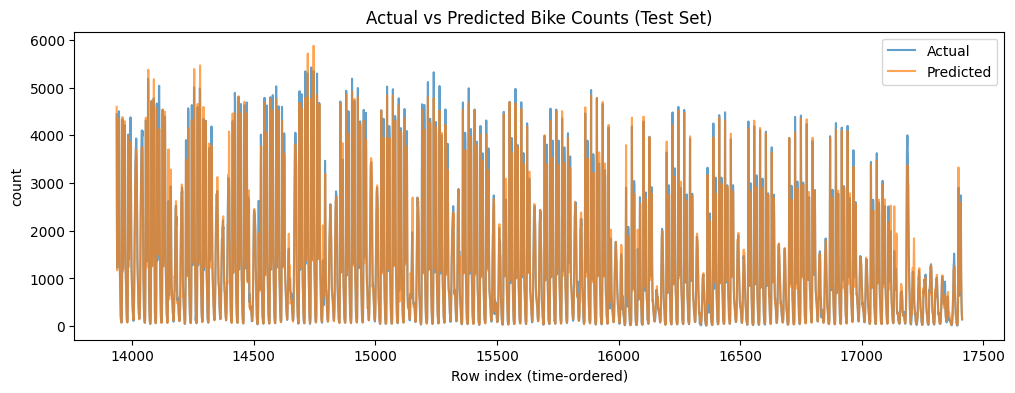

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Bike Counts (Test Set)")
plt.xlabel("Row index (time-ordered)")
plt.ylabel("count")
plt.show()

In [10]:
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
importances

cnt_lag_1            0.656189
cnt_lag_24           0.124690
is_rush_hour         0.085293
hour                 0.054422
cnt_roll_mean_24h    0.018196
is_working_hour      0.017127
weekday              0.016265
is_weekend_bool      0.010039
hum                  0.006973
t1                   0.006908
wind_speed           0.002140
month                0.001758
dtype: float64

<Axes: title={'center': 'Top Feature Importances'}>

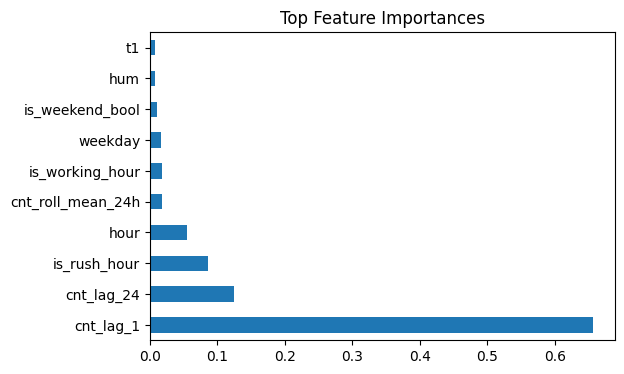

In [11]:
importances.head(10).plot(kind="barh", figsize=(6, 4), title="Top Feature Importances")